In [210]:
from __future__ import annotations

import json
import os
from pathlib import Path
from queue import Queue

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from librosa import load, feature
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# REPLACE THIS WITH YOUR LOCAL FILES PATH IF YOU WANT TO RECOMPUTE FEATURE EXTRACTION
PATH_TO_FILES = Path('files/')

PATH_TO_JSON = 'data.json'

# Final Project: Genre Detection
## By: Jack Hayley, Matthew McCollum, Mikhail Titov
### Notes
- All self-defined methods are documented and explained using comments
- Each model includes an explanation and analysis

In [211]:
class FileParser:
    """
    This class essentially makes it easier to integrate individual file-processing in the code.
    
    It ensures that only certain suffixes are to be extracted (avoids unwanted/metadata files).
    
    Done efficiently with a FIFO queue structure.
    
    Authors:
        Jack Hayley
    """
    
    suffixes: set
    _queue: Queue

    def __init__(self, root, suffixes):
        # Get the path to the root directory
        self.root = Path(root)
        # Initialize the queue
        self._queue = Queue()
        # Initialize the suffixes that can be extracted
        self.suffixes = suffixes
        # Put the root directory in the queue to initialize get_next_file state
        self._queue.put(self.root)

    def get_next_file(self) -> Path | ... | None:
        """

        Gets the path to the next file in the queue.
        
        Works when we only want one file at a time.
        
        :return: 
            path to file, if the path's suffix is in the suffix list
            ..., if the path's suffix isn't in the suffix list
            None, if the queue is empty 
        """
        
        # If the Queue is empty, all possible files have been traversed
        if self._queue.empty():
            print("Queue is empty")
            return None

        # Get the next file path
        res = self._queue.get()
        # If the path is a directory, add all
        if res.is_dir():
            for child in res.iterdir():
                if child.suffix[1:].lower() in self.suffixes or child.is_dir():
                    self._queue.put(child)
            return Ellipsis
        else:
            # Examines to see if suffix is in the specified set
            return res if res.suffix[1:] in self.suffixes else Ellipsis

class FileIO:
    """
    This class allows easy reading and writing to a JSON file.
    
    It also formats the results such that they are readable.
    
    Authors:
        Jack Hayley
    """
    
    _data: list

    def __init__(self, path):
        # Get the file path to the JSON file
        self.path = Path(path)
        # Data is not extracted for now, just defined as class variable
        self._data = ...
    
    def get_data(self) -> list:
        """
        Retrieves data in JSON as a list of dictionaries

        :return: formatted data from the JSON file
        """
        
        with open(self.path) as json_file:
            self._data = json.load(json_file)
        return self._data
    
    def set_data_from_raw(self, data):
        """
        Exports raw python data to JSON.

        :param data: formatted list to add to JSON
        """
        
        if type(data) is list:
            self._data = sorted(data, key=lambda x: x['id'])
            with open(self.path, 'w') as json_file:
                # This external method makes the file look pretty and readable.
                json_file.write(json.dumps(self._data, sort_keys=False, indent=4))
    
    def set_data_from_frame(self, df: pd.DataFrame):
        """
        Exports a DataFrame to JSON.

        :param df: formatted DataFrame to add to JSON
        """
        
        with open(self.path, 'w') as json_file:
            # noinspection PyTypeChecker
            self._data = sorted(list(df.to_dict(orient='records')), key=lambda x: x['id'])
            json_file.write(json.dumps(self._data, sort_keys=False, indent=4))
            
        
        

In [212]:
class FeatureExtractor:
    """
    This is a wrapper class that abstracts the feature extraction from librosa.
    
    Basically it's to make it easy to extract and flatten data for analysis.
    
    Also, increases space efficiency as only the flattened values are cached.
    
    Note: have to convert numpy arrays to list in order to parse into JSON.
    
    Authors:
        Jack Hayley
        Matthew McCollum
        Mikhail Titov
    """
    
    def __init__(self):
        # Change the number of MFCCs (13 are perceptually relevant)
        self.mfccs = 13
        # Set the sample rate for librosa
        self.rate = 22050
    
    def not_static(self):
        """
        Method to ensure all the methods aren't static... because PyCharm.
        """
        
        pass
    
    def tempo(self, audio) -> float:
        """
        Extracts tempo.
        
        :param audio: the file to analyze
        :return: the average tempo
        """
        return np.mean(feature.tempo(y=audio, sr=self.rate).tolist())
    
    def rms(self, audio) -> float:
        """
        Extracts rms.
        
        :param audio: the file to analyze
        :return: the average rms
        """
        
        self.not_static()
        return np.mean(feature.rms(y=audio).tolist())
    
    def mfcc(self, audio) -> list:
        """
        Extracts the first 'n' MFCCs.
        
        :param audio: the file to analyze
        :return: the average value of each MFCC
        """
        
        return np.mean(feature.mfcc(y=audio, sr=self.rate, n_mfcc=self.mfccs).tolist(), axis=1)
    
    def bandwidth(self, audio) -> float:
        """
        Extracts spectral bandwidth.
        
        :param audio: the file to analyze
        :return: the average spectral bandwidth.
        """
        
        return np.mean(feature.spectral_bandwidth(y=audio, sr=self.rate).tolist())
    
    def centroid(self, audio) -> float:
        """
        Extracts spectral centroid.
        
        :param audio: the file to analyze
        :return: the average spectral centroid.
        """
        
        return np.mean(feature.spectral_centroid(y=audio, sr=self.rate).tolist())
    
    def contrast(self, audio) -> float:
        """
        Extracts spectral contrast.
        
        :param audio: the file to analyze
        :return: the average spectral contrast.
        """
        
        return np.mean(feature.spectral_contrast(y=audio, sr=self.rate).tolist())
    
    def rolloff(self, audio) -> float:
        """
        Extracts spectral rolloff.
        
        :param audio: the file to analyze
        :return: the average spectral rolloff.
        """
        
        return np.mean(feature.spectral_rolloff(y=audio, sr=self.rate).tolist())
    
    def zcr(self, audio) -> float:
        """
        Extracts zero-crossing rate.
        
        :param audio: the file to analyze
        :return: the average zero-crossing rate.
        """
        
        self.not_static()
        return np.mean(feature.zero_crossing_rate(y=audio).tolist())
    

In [213]:
class Model:
    """
    This class is a wrapper for the sklean regression model.
    
    This allows us to generate multiple models conveniently without clashing.
    
    Authors:
        Jack Hayley
        Matthew McCollum
        Mikhail Titov
    """
    def __init__(self, dt: list, features):
        # Import data and convert to DataFrame
        self.dt = dt
        self.df = pd.DataFrame(dt)
        
        # Define predictors and features from DataFrame
        self.features = features
        self.categories = self.df[['genre']]
        self.predictors = self.df[features]
        self.predictors.columns = features
        
        # These will be defined later
        self.model = ...
        self.split_data = ...
        self.res = ...
    
    def generate_model(self, test_size=0.33, solver='newton-cg', iters=1000):
        """
        Generates genre predictions for the model based off the predictors

        :param test_size: % of data to use for testing
        :param solver: just use newton-cg
        :param iters: the maximum amount of iterations given for the model to converge 
        """
        
        # Split the DataFrame into training data and testing data
        self.split_data = train_test_split(self.predictors, self.categories, test_size=test_size, random_state=5)
        pre_train, pre_test, cat_train, cat_test = self.split_data
        
        # Standardizing the predictors (needed for things like MFCCs etc.)
        scaler = StandardScaler()
        pre_train_scaled = scaler.fit_transform(pre_train)
        pre_test_scaled = scaler.transform(pre_test)

        # Fitting the multinomial logistic regression model
        self.model = LogisticRegression(multi_class='multinomial', solver=solver, max_iter=iters)
        self.model.fit(pre_train_scaled, cat_train.genre)
        self.res = self.model.predict(pre_test_scaled)
        
        # Updating the DataFrame to include predictions
        self.df.loc[pre_test.index, 'prediction'] = self.res
    
    def get_matrix(self):
        """
        
        :return: the confusion matrix
        """
        
        return confusion_matrix(self.split_data[3], self.res)
    
    def get_report(self):
        """

        :return: the classification report
        """
        
        return classification_report(self.split_data[3], self.res)

In [214]:
def get_heatmap(matrix):
    #Visualize Confusion Matrix
    confusion_matrix_data = matrix

    # Genre labels
    labels = ['Classical', 'HipHop', 'Jazz', 'Pop', 'Reggae']

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Create the heatmap
    cax = ax.matshow(confusion_matrix_data, cmap=plt.cm.Blues)

    # Add color bar
    fig.colorbar(cax)

    # Set the locations and labels of the ticks (small lines under axes)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)

    # Set axis titles
    ax.set_xlabel('True Genre')
    ax.set_ylabel('Predicted Genre')

    # Loop over the actual confusion matrix to get the values and format them into the heatmap.
    for (i, j), val in np.ndenumerate(confusion_matrix_data):
        ax.text(j, i, val, ha='center', va='center', 
            color='white' if val > np.max(confusion_matrix_data)/2 else 'black')

    plt.show()

def box_genres(df, feature):
    # Choose the MFCC feature you're interested in

    # Unique genres in your dataframe
    genres = m1.df['genre'].unique()

    # Data to plot
    data_to_plot = [df[df['genre'] == genre][feature] for genre in genres]

    # Create a figure instance
    fig = plt.figure(figsize=(10, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    ax.boxplot(data_to_plot)

    # Set the tick labels on the x-axis to correspond to genres
    ax.set_xticklabels(genres, rotation=45)

    # Set the labels and title
    ax.set_title(f'Distribution of {feature} Across Genres')
    ax.set_xlabel('Genre')
    ax.set_ylabel('Value of ' + feature)
    
    ax.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

    # Show the plot
    plt.show()

In [215]:
### ONLY RUN THIS CELL TO EXTRACT FEATURES
DATA = []
if input("ONLY INPUT SOMETHING IF YOU WANT TO RECOMPUTE FEATURES - OTHERWISE JUST PRESS ENTER"):
    # Create instances of classes - only .au files permitted
    finder = FileParser(PATH_TO_FILES, ('au',))
    output = FileIO(PATH_TO_JSON)
    extractor = FeatureExtractor()
    
    # Loop until file parser doesn't return anything
    while True:
        curr = finder.get_next_file()
        if not curr:
            # Ran out of files, so stop
            break
        elif curr is ...:
            # File is not correct type, so skip
            continue
        else:
            # Load current file that is trimmed
            curr_file, fs = load(curr, duration=7, sr=extractor.rate)
            
            # Extract all the features in one line, and convert it to a dictionary
            DATA.append(dict(
                id=curr.name,
                genre=curr.parent.name,
                # This is a way to make each MFCC key-val pair separate w/out having to manually list mfcc0, mfcc1, ...
                **dict(zip((f'mfcc{n}' for n in range(extractor.mfccs)), extractor.mfcc(curr_file))),
                tempo=extractor.tempo(curr_file),
                rms=extractor.rms(curr_file),
                bandwidth=extractor.bandwidth(curr_file),
                centroid=extractor.centroid(curr_file),
                contrast=extractor.contrast(curr_file),
                rolloff=extractor.rolloff(curr_file),
                zcr=extractor.zcr(curr_file),
                prediction='training'
            ))
    
    # Export to JSON
    output.set_data_from_raw(DATA)
    print('Success')

In [216]:
### OLD CODE

# test_features = [*(f'mfcc{n}' for n in range(extractor.mfccs // 2)), 'zcr']
# 
# frame = pd.DataFrame(data)
# categories = frame[['genre']]
# predictors = frame[test_features]
# predictors.columns = test_features
# 
# pre_train, pre_test, cat_train, cat_test = train_test_split(predictors, categories, test_size=0.33, random_state=5)
# model = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=1000)
# model.fit(pre_train, cat_train.genre)
# predictions = model.predict(pre_test)
# print(confusion_matrix(cat_test, predictions))
# print(classification_report(cat_test, predictions))

In [217]:
### RUN THIS CELL TO GET THE DATA WITHOUT RE-EXTRACTING THE FEATURES 
DATA = FileIO(PATH_TO_JSON).get_data()

In [154]:
# model 1
# Change the list in this constructor to change the features analyzed (names must match JSON file)
m1 = Model(DATA, [*(f'mfcc{n}' for n in range(10))])
m1.generate_model()
print(m1.get_report())

              precision    recall  f1-score   support

   classical       0.83      0.62      0.71        16
      hiphop       0.69      0.55      0.61        20
        jazz       0.62      0.91      0.74        11
         pop       0.68      0.95      0.79        20
      reggae       0.55      0.38      0.44        16

    accuracy                           0.67        83
   macro avg       0.67      0.68      0.66        83
weighted avg       0.68      0.67      0.66        83



In [155]:
# model 2
# Change the list in this constructor to change the features analyzed (names must match JSON file)
m2 = Model(DATA, [*(f'mfcc{n}' for n in range(10)), 'rms'])
m2.generate_model()
print(m2.get_report())

              precision    recall  f1-score   support

   classical       0.82      0.56      0.67        16
      hiphop       0.71      0.60      0.65        20
        jazz       0.59      0.91      0.71        11
         pop       0.70      0.95      0.81        20
      reggae       0.64      0.44      0.52        16

    accuracy                           0.69        83
   macro avg       0.69      0.69      0.67        83
weighted avg       0.70      0.69      0.67        83



In [167]:
# model 3
# Change the list in this constructor to change the features analyzed (names must match JSON file)
m3 = Model(DATA, [*(f'mfcc{n}' for n in range(10)), 'rms', 'zcr'])
m3.generate_model()
print(m3.get_report())

              precision    recall  f1-score   support

   classical       0.75      0.56      0.64        16
      hiphop       0.71      0.60      0.65        20
        jazz       0.60      0.82      0.69        11
         pop       0.69      0.90      0.78        20
      reggae       0.62      0.50      0.55        16

    accuracy                           0.67        83
   macro avg       0.67      0.68      0.66        83
weighted avg       0.68      0.67      0.67        83



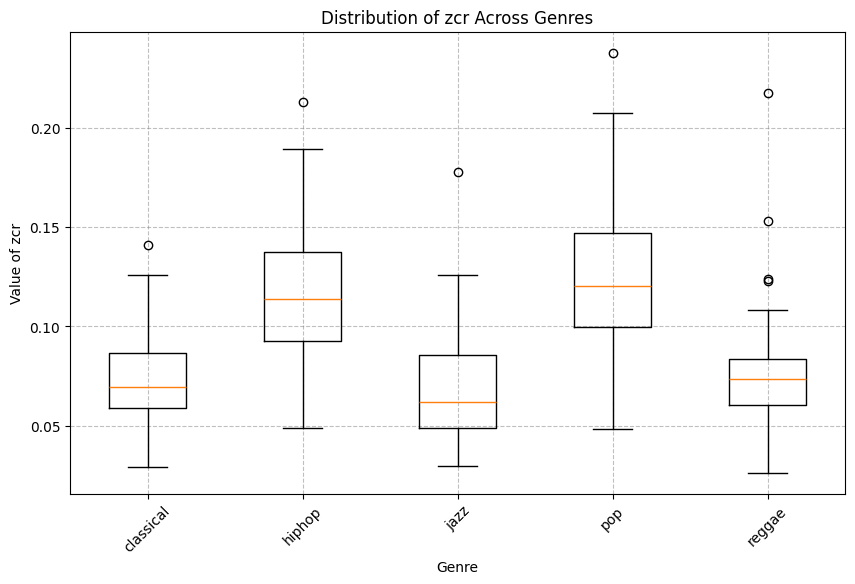

In [168]:
box_genres(m3.df, 'zcr')

In [170]:
# Final Model
mF = Model(DATA, [*(f'mfcc{n}' for n in range(10)), 'tempo', 'rms', 'bandwidth', 'centroid', 'contrast', 'rolloff'])
mF.generate_model()
print(mF.get_report())

              precision    recall  f1-score   support

   classical       0.80      0.75      0.77        16
      hiphop       0.78      0.70      0.74        20
        jazz       0.82      0.82      0.82        11
         pop       0.73      0.95      0.83        20
      reggae       0.77      0.62      0.69        16

    accuracy                           0.77        83
   macro avg       0.78      0.77      0.77        83
weighted avg       0.77      0.77      0.77        83



              precision    recall  f1-score   support

   classical       0.75      0.75      0.75        16
      hiphop       0.61      0.55      0.58        20
        jazz       0.75      0.82      0.78        11
         pop       0.65      0.85      0.74        20
      reggae       0.64      0.44      0.52        16

    accuracy                           0.67        83
   macro avg       0.68      0.68      0.67        83
weighted avg       0.67      0.67      0.67        83



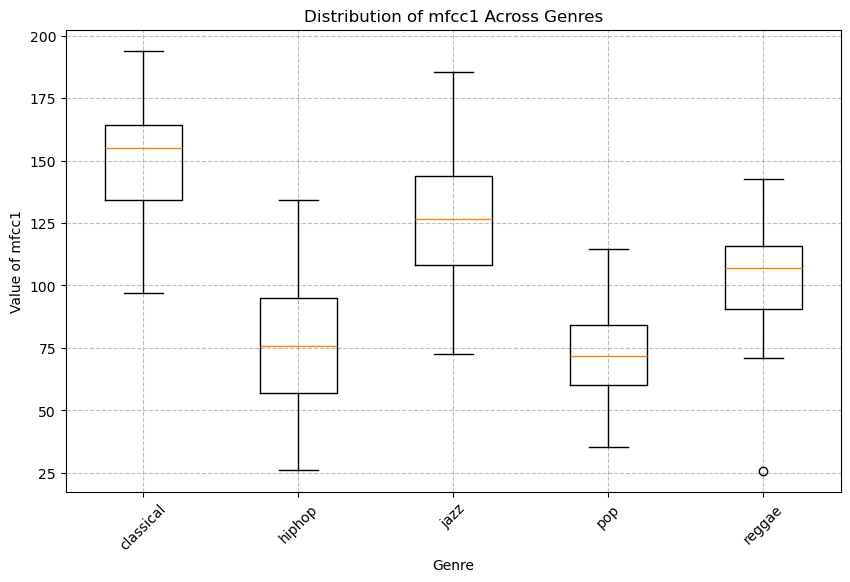

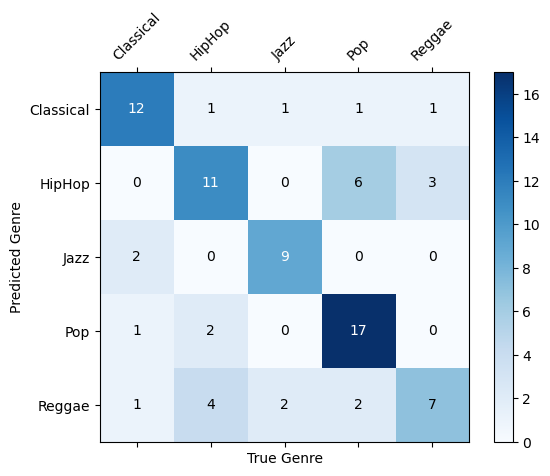

In [218]:
### EXAMPLE MODEL



# Change the list in this constructor to change the features analyzed (names must match JSON file)
m1 = Model(DATA,
           [*(f'mfcc{n}' for n in range(10)), 
            'contrast',
            'zcr']
           )

# Add parameters to change model functionality
m1.generate_model()

FileIO(PATH_TO_JSON).set_data_from_frame(m1.df)

print(m1.get_report())

box_genres(m1.df, 'mfcc1')
get_heatmap(m1.get_matrix())

              precision    recall  f1-score   support

   classical       0.86      0.75      0.80        16
      hiphop       0.87      0.65      0.74        20
        jazz       0.69      0.82      0.75        11
         pop       0.68      0.95      0.79        20
      reggae       0.77      0.62      0.69        16

    accuracy                           0.76        83
   macro avg       0.77      0.76      0.75        83
weighted avg       0.78      0.76      0.76        83



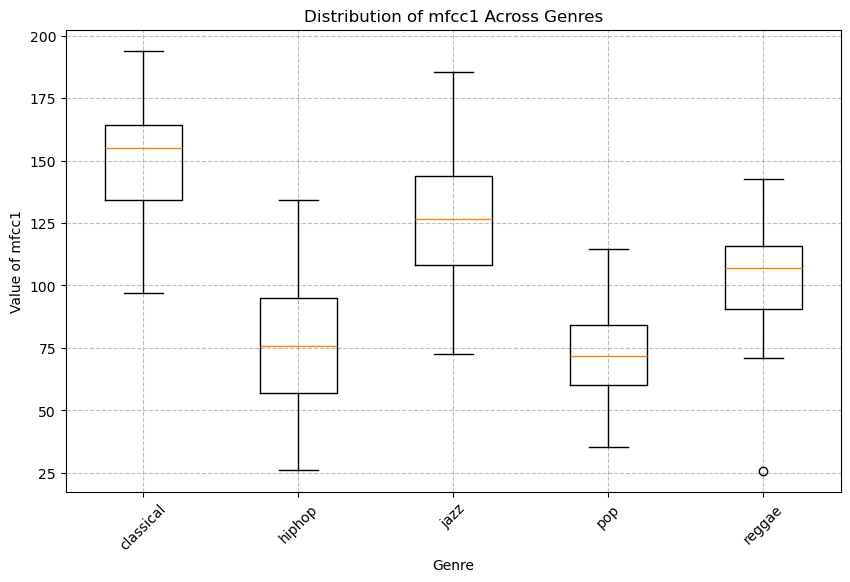

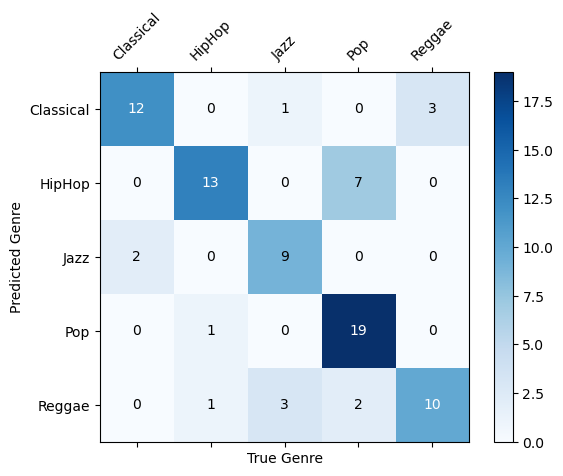

In [219]:
mF2 = Model(DATA, [*(f'mfcc{n}' for n in range(1,5)), 'rms', 'tempo', 'contrast', 'rolloff'])

# Add parameters to change model functionality
mF2.generate_model()

FileIO(PATH_TO_JSON).set_data_from_frame(mF2.df)

print(mF2.get_report())

box_genres(mF2.df, 'mfcc1')
get_heatmap(mF2.get_matrix())
